In [2]:
import os, glob
import soundfile as sf
import numpy as np
import pandas as pd
import h5py
import tqdm
import IPython
import fairseq
import torch
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn import metrics
import seaborn as sns
import utils
from fairseq.dataclass.utils import convert_namespace_to_omegaconf

2021-11-24 15:41:34 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX


In [2]:
fairseq.__version__

'1.0.0a0+7fd6435'

In [2]:
from fairseq.models.wav2vec.wav2vec2 import Wav2Vec2Model

In [3]:
# model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task(['./pretrained_checkpoints/wav2vec_small_10m.pt'], arg_overrides={"data": "./data"})

In [4]:
# # 0.10.2
# # Check this file: ~/miniconda/lib/python3.8/site-packages/fairseq/models/wav2vec/wav2vec2.py
# wav2vec2 = fairseq.models.wav2vec.Wav2Vec2Model.build_model(checkpoint['args'])
# wav2vec2.load_state_dict(checkpoint['model'])
# audio = torch.randn(1,10000)
# output = wav2vec2(audio)

In [14]:
# fairseq hydra-core-1.0.7 (pip install --editable ./)
from fairseq.dataclass.utils import convert_namespace_to_omegaconf

# audio = torch.randn(1,10000)
# features = wav2vec2(audio, features_only=True, mask=False)

NameError: name 'checkpoint2' is not defined

In [6]:
def wav2vec2forward(model, source, aggregation=True, hidden_layer=None):
    """
    Inference function of pretrained wav2vec2 to extract intermediate representations
    Ref: https://github.com/pytorch/fairseq/blob/89ec6e7efff867d258947acafc57189b257212d0/fairseq/models/wav2vec/wav2vec2.py
    """
    
    with torch.no_grad():
        cnn_features = model.feature_extractor(source)
    
        cnn_features = cnn_features.transpose(1, 2)
        features = model.layer_norm(cnn_features)

        if model.quantizer: # this is not None in pretrained w2v
            q = model.quantizer(features, produce_targets=False)
            quantized_features = q["x"]
            projected_quantized_features = model.project_q(quantized_features)

        if model.post_extract_proj is not None: # this is not None in pretrained w2v
            features = model.post_extract_proj(features)

        if model.input_quantizer is not None: # this is None in pretrained w2v
            q = model.input_quantizer(features, produce_targets=False)
            features = q['x']
            features = model.project_inp(features)
            
        encoder_outputs, encoder_layers_features = model.encoder(features, padding_mask=None, layer=hidden_layer)
            
        context_vectors = model.final_proj(encoder_outputs)
        
        ret = dict()
        ret['cnn_output'] = cnn_features[0]
        ret['vq'] = quantized_features[0]
        ret['projected_vq'] = projected_quantized_features[0]
        ret['encoder_output'] = encoder_outputs[0]
        ret['context_vector'] = context_vectors[0]
        if len(encoder_layers_features) > 0:
            ret['encoder_hiddens'] = [h[0][0] for h in encoder_layers_features]
        
        if aggregation:
            ret['cnn_output'] = torch.mean(ret['cnn_output'], dim=0)
            ret['vq'] = torch.mean(ret['vq'], dim=0)
            ret['projected_vq'] = torch.mean(ret['projected_vq'], dim=0)
            ret['encoder_output'] = torch.mean(ret['encoder_output'], dim=0)
            ret['context_vector'] = torch.mean(ret['context_vector'], dim=0)
            if len(encoder_layers_features) > 0:
                ret['encoder_hiddens'] = [torch.mean(h, dim=0) for h in ret['encoder_hiddens']]
        
        return ret

In [39]:
audio = torch.randn(1,32000).cuda()
ret = wav2vec2forward(wav2vec2, audio, aggregation=False)
ret.keys()

dict_keys(['cnn_output', 'vq', 'projected_vq', 'encoder_output', 'context_vector'])

In [74]:
for key in ret.keys():
    print(key, ret[key].shape)

cnn_features torch.Size([1, 512, 99])
quantized_features torch.Size([1, 99, 256])
encoder_outputs torch.Size([1, 99, 768])
context_vectors torch.Size([1, 99, 256])


## VTCK

In [218]:
corpus_dir = './data/data/TEST/'

In [18]:
!rm -rf ./outputs/wav2vec2_small/VTCK.h5

In [19]:
## Create a h5py file
## https://www.christopherlovell.co.uk/blog/2016/04/27/h5py-intro.html
hf = h5py.File('./outputs/wav2vec2_small/VTCK.h5', 'w')

In [21]:
hf.close()

In [23]:
list_speakers = glob.glob(f"{corpus_dir}/*")

In [24]:
wav_idx = []
wav_paths = []
for speaker_dir in tqdm.tqdm(list_speakers):
    speaker_id = os.path.basename(speaker_dir)
    
    for wav_path in glob.glob(f"{speaker_dir}/*.wav"):
        wav_id, ext = os.path.basename(wav_path).split('.')
        wav_idx.append(wav_id)
        wav_paths.append(wav_path)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:05<00:00, 21.61it/s]


In [221]:
dialects = []
sentences = []
speakers = []
wav_paths = []
wav_ids = []
for file_path in glob.glob("./data/data/TEST/*/*/*.wav"):
    dialect = file_path.split(os.sep)[-3]
    speaker = file_path.split(os.sep)[-2]
    sentence = file_path.split(os.sep)[-1][:-4]
    wav_ids.append(f"{dialect}_{speaker}_{sentence}")
    wav_paths.append(file_path)
    dialects.append(dialect)
    sentences.append(sentence)
    speakers.append(speaker)

In [223]:
df = pd.DataFrame(list(zip(wav_ids, wav_paths, dialects, speakers, sentences)), columns =['wav_id', 'wav_path', 'dialect', 'speaker', 'sentence'])
df.to_csv("./data/TIMIT_test.csv", index=False)

In [14]:
df = pd.read_csv("./data/VCTK.csv")

In [9]:
dialects = [wav_id.split('_')[0] for wav_id in df['wav_id']]
sentences = [wav_id.split('_')[-1].split('.')[0] for wav_id in df['wav_id']]
speakers = [wav_id.split('_')[1] for wav_id in df['wav_id']]

In [16]:
df['speaker'] = [wav_id.split('_')[0] for wav_id in df['wav_id']]

In [13]:
len(set(df['sentence']))

1718

In [17]:
df.to_csv("./data/VCTK.csv", index=False)

In [20]:
for speaker_dir in tqdm.tqdm(list_speakers):
    speaker_id = os.path.basename(speaker_dir)
    
    for wav_path in glob.glob(f"{speaker_dir}/*.wav"):
        wav_id, ext = os.path.basename(wav_path).split('.')
        audio, sr = sf.read(wav_path, dtype='float32')
        audio = torch.from_numpy(audio).unsqueeze(0).cuda()
        output = wav2vec2forward(wav2vec2, audio)
        
        hf.create_dataset(f"{wav_id}-cnn_features", data=output['cnn_features'].cpu())
        hf.create_dataset(f"{wav_id}-quantized_features", data=output['quantized_features'].cpu())
        hf.create_dataset(f"{wav_id}-encoder_outputs", data=output['encoder_outputs'].cpu())
        hf.create_dataset(f"{wav_id}-context_vectors", data=output['context_vectors'].cpu())
        if 'encoder_hiddens' in output:
            hf.create_dataset(f"{wav_id}-encoder_hiddens", data=torch.stack([h[0].cpu() for h in output['encoder_hiddens']]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [30:32<00:00, 16.82s/it]


In [88]:
IPython.display.Audio(data=audio, rate=sr)

In [64]:
hf = h5py.File('./outputs/wav2vec2_small/VTCK.h5', 'r')

In [66]:
list(hf.keys())[0]

'p225_001-cnn_features'

In [67]:
embeddings = []
labels = []
for key in hf.keys():
    if 'cnn_features' in key:
        embeddings.append(np.mean(hf[key][0], axis=1))
        labels.append(key.split('-')[0].split('_')[0])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 44242 samples in 0.017s...
[t-SNE] Computed neighbors for 44242 samples in 50.252s...
[t-SNE] Computed conditional probabilities for sample 1000 / 44242
[t-SNE] Computed conditional probabilities for sample 2000 / 44242
[t-SNE] Computed conditional probabilities for sample 3000 / 44242
[t-SNE] Computed conditional probabilities for sample 4000 / 44242
[t-SNE] Computed conditional probabilities for sample 5000 / 44242
[t-SNE] Computed conditional probabilities for sample 6000 / 44242
[t-SNE] Computed conditional probabilities for sample 7000 / 44242
[t-SNE] Computed conditional probabilities for sample 8000 / 44242
[t-SNE] Computed conditional probabilities for sample 9000 / 44242
[t-SNE] Computed conditional probabilities for sample 10000 / 44242
[t-SNE] Computed conditional probabilities for sample 11000 / 44242
[t-SNE] Computed conditional probabilities for sample 12000 / 44242
[t-SNE] Computed conditional probabilities for s

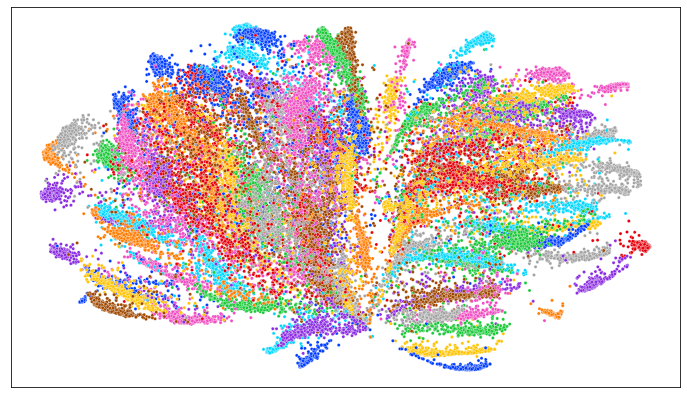

In [68]:
vis_tSNE(embeddings, labels)

In [ ]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(encoder_outputs_embeddings, encoder_outputs_labels)

#Predict the response for test dataset
y_pred = clf.predict(encoder_outputs_embeddings)

print("Accuracy encoder_outputs:",metrics.accuracy_score(encoder_outputs_labels, y_pred))

## TIMIT

In [ ]:
## wget https://data.deepai.org/timit.zip

In [96]:
IPython.display.Audio(filename="./data/data/TEST/DR1/FAKS0/")

In [14]:
def vis_tSNE(embeddings, labels):
    ## Apply t-SNE for visualization
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(embeddings)
    
    data = {'x': tsne_results[:,0],
        'y': tsne_results[:,1],
       'labels': labels}
  
    # Create DataFrame
    df = pd.DataFrame(data)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    ax.set_xticks([])
    ax.set_yticks([])
    g = sns.scatterplot(x="x", y="y",
                      hue="labels",
                      data=df,s=20, legend=False, ax=ax,
                       palette=sns.color_palette(n_colors=len(set(labels))));

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4620 samples in 0.002s...
[t-SNE] Computed neighbors for 4620 samples in 0.502s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4620
[t-SNE] Computed conditional probabilities for sample 2000 / 4620
[t-SNE] Computed conditional probabilities for sample 3000 / 4620
[t-SNE] Computed conditional probabilities for sample 4000 / 4620
[t-SNE] Computed conditional probabilities for sample 4620 / 4620
[t-SNE] Mean sigma: 0.019936
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.950668
[t-SNE] KL divergence after 300 iterations: 2.837030


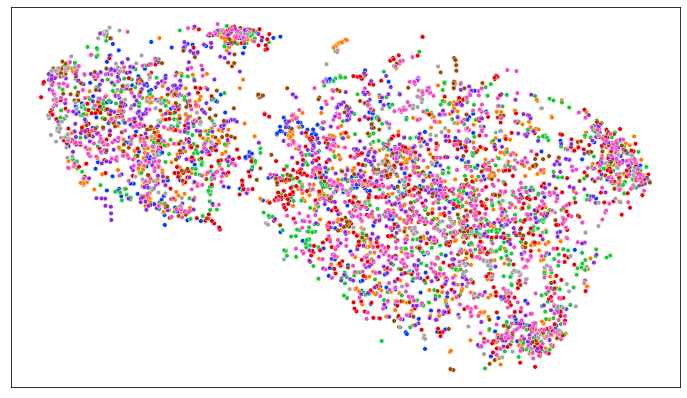

In [9]:
vis_tSNE(embeddings, labels)

In [16]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(embeddings, labels)

#Predict the response for test dataset
y_pred = clf.predict(embeddings)

print("Accuracy encoder_outputs:",metrics.accuracy_score(labels, y_pred))

Accuracy encoder_outputs: 0.5064935064935064


In [131]:
hf = h5py.File("./outputs/extracted_features/wav2vec2_small-random_init/TIMIT_train_averaged.h5", 'r')

In [178]:
md = pd.read_csv("./data/TIMIT_train.csv")

# Plot variances

In [20]:
def wav2vec2featurize(model, source, feature_name):
    """
    Inference function of pretrained wav2vec2 to extract intermediate representations
    Ref: https://github.com/pytorch/fairseq/blob/89ec6e7efff867d258947acafc57189b257212d0/fairseq/models/wav2vec/wav2vec2.py
    """
    assert feature_name in ['cnn_output', 'vq', 'projected_vq', 'encoder_output', 'context_vector']
    cnn_features = model.feature_extractor(source)

    cnn_features = cnn_features.transpose(1, 2)
    
    if feature_name == 'cnn_output':
        return cnn_features.squeeze(0)
    
    features = model.layer_norm(cnn_features)

    if model.quantizer: # this is not None in pretrained w2v
        q = model.quantizer(features, produce_targets=False)
        quantized_features = q["x"]
        if feature_name == 'vq':
            return quantized_features.squeeze(0)
        projected_quantized_features = model.project_q(quantized_features)
        if feature_name == 'projected_vq':
            return projected_quantized_features.squeeze(0)

    if model.post_extract_proj is not None: # this is not None in pretrained w2v
        features = model.post_extract_proj(features)

    if model.input_quantizer is not None: # this is None in pretrained w2v
        q = model.input_quantizer(features, produce_targets=False)
        features = q['x']
        features = model.project_inp(features)

    encoder_outputs, encoder_layers_features = model.encoder(features, padding_mask=None, layer=None)
    
    if feature_name == 'encoder_output':
        return encoder_outputs.squeeze(0)

    context_vectors = model.final_proj(encoder_outputs)

    return context_vectors.squeeze(0)

In [213]:
def compute_external_var_label(hf, df, feature_name, fixed_column):
    all_var = []
    for label in set(list(df[fixed_column])):
        app = len(df[df[fixed_column]==label])
        if app > 5:
            extracted_features = []
            for i, row in df[df[fixed_column] == label].iterrows():
                extracted_features.append(np.array(hf[row['wav_id'] + '-' + feature_name]))
            extracted_features = np.vstack(extracted_features)
            all_var.append(np.var(extracted_features, axis=0) / np.mean(extracted_features, axis=0))
    
    var = np.mean(np.vstack(all_var), axis=0)
    return var


def compute_external_var(hf, df, feature_name):
    extracted_features = []
    for i in range(len(df)):
        extracted_features.append(np.array(hf[df.iloc[i]['wav_id'] + '-' + feature_name]))
    
    extracted_features = np.vstack(extracted_features)
    var = np.var(extracted_features, axis=0) / np.mean(extracted_features, axis=0)
    return var


def compute_internal_var(model, df, feature_name):
    all_var = []
    for i in range(len(df)):
        x, sr = sf.read(df.iloc[i]['wav_path'], dtype='float32')
        x = torch.tensor(x).unsqueeze(0).cuda()
        with torch.no_grad():
            features = wav2vec2featurize(model, x, feature_name)
        all_var.append(torch.var(features, dim=0) / torch.mean(features, dim=0))
    
    var = torch.mean(torch.stack(all_var), dim=0)
    return var.cpu().numpy()

In [192]:
def compute_linguistic_acoustic_activity(model, df, feature_name):
    """
    Fix sentence, change speakers to get acoustic activity
    In each sentence, compute variance across frames to get linguistic activity
    """
    linguistic_activities = []
    acoustic_activities = []
    neuron_means = []
    
    with torch.no_grad():
        for sent in set(list(df['sentence'])):
            n = len(df[df['sentence'] == sent])
            if n >= 7: # at least 7 speakers speak this sentence
                feature_mean, feature_var = [], []
                for i, row in df[df['sentence'] == sent].iterrows():
                    x, sr = sf.read(row['wav_path'], dtype='float32')
                    x = torch.tensor(x).unsqueeze(0).cuda()
                    feature = wav2vec2featurize(model, x, feature_name).cpu().detach()
                    feature_mean.append(torch.mean(feature, dim=0))
                    feature_var.append(torch.var(feature, dim=0))

                feature_mean = torch.stack(feature_mean)
                feature_var = torch.stack(feature_var)
                linguistic_activities.append(torch.mean(feature_var, dim=0).numpy())
                acoustic_activities.append(torch.var(feature_mean, dim=0).numpy())
                neuron_means.append(torch.mean(feature_mean, dim=0).numpy())
    
    neuron_means = np.vstack(neuron_means)
    neuron_means = np.mean(neuron_means, axis=0)
    linguistic_activities = np.vstack(linguistic_activities)
    acoustic_activities = np.vstack(acoustic_activities)
    
    return linguistic_activities, acoustic_activities, neuron_means

In [8]:
def compute_linguistic_random_activity(hf, df, feature_name, fixed_property='speaker'):
    """
    Fix speaker, change sentence then get expectation of variance
    Compute the ratio of this with the obtained expectation when utterances are sampled randomly
    If this ratio > 1 -> linguistic activity else acoustic activity
    """
    random_activities = []
    
    S = 7 if fixed_property == 'sentence' else 10
    
    for _ in range(len(df) // S):
        features = []
        for _, row in df.sample(S).iterrows():
            feature = hf[row['wav_id'] + '-' + feature_name][:]
            features.append(feature)
        random_activities.append(np.var(np.vstack(features), axis=0))
            
    random_activities = np.mean(random_activities, axis=0)
    
    fix_speaker_activities = []
    
    for prop in set(list(df[fixed_property])):
        n = len(df[df[fixed_property] == prop])
        if n == S: # this speaker speak 10 sentences
            features = []
            for _, row in df[df[fixed_property] == prop].iterrows():
                feature = hf[row['wav_id'] + '-' + feature_name][:]
                features.append(feature)
            fix_speaker_activities.append(np.var(np.vstack(features), axis=0))

    fix_speaker_activities = np.mean(fix_speaker_activities, axis=0)
    
    return fix_speaker_activities, random_activities

In [11]:
hf = h5py.File("./outputs/extracted_features/wav2vec2_small_960h/TIMIT_train_averaged.h5", 'r')
feat = 'context_vector'
acoustic_activities, random_activities = compute_linguistic_random_activity(hf, df, feat, fixed_property='speaker')
acoustic_activities /= random_activities

In [12]:
linguistic_activities, random_activities = compute_linguistic_random_activity(hf, df, feat, fixed_property='sentence')
linguistic_activities /= random_activities

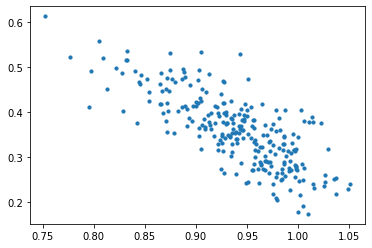

In [13]:
plt.scatter(acoustic_activities, linguistic_activities, s=10)

In [311]:
hf = h5py.File("./outputs/extracted_features/wav2vec2_small-random_init//TIMIT_train_averaged.h5", 'r')
for feat in ['cnn_output', 'vq', 'projected_vq', 'encoder_output', 'context_vector']:
    linguistic_activities, random_activities = compute_linguistic_random_activity(hf, df, feat)
    print(feat, np.mean(linguistic_activities / random_activities))

cnn_output 0.9834003
vq 0.9471694
projected_vq 0.95045054
encoder_output 0.89024264
context_vector 0.8926065


In [317]:
# fix speaker
hf = h5py.File("./outputs/extracted_features/wav2vec2_small-random_init//TIMIT_train_averaged.h5", 'r')
for feat in ['cnn_output', 'vq', 'projected_vq', 'encoder_output', 'context_vector']:
    linguistic_activities, random_activities = compute_linguistic_random_activity(hf, df, feat)
    print(feat, np.mean(linguistic_activities / random_activities))

cnn_output 0.81971747
vq 0.92703766
projected_vq 0.9377241
encoder_output 0.87364084
context_vector 0.89070565


In [312]:
hf = h5py.File("./outputs/extracted_features/wav2vec2_small/TIMIT_train_averaged.h5", 'r')
for feat in ['cnn_output', 'vq', 'projected_vq', 'encoder_output', 'context_vector']:
    linguistic_activities, random_activities = compute_linguistic_random_activity(hf, df, feat)
    print(feat, np.mean(linguistic_activities / random_activities))

cnn_output 0.67890733
vq 0.6149556
projected_vq 0.5605876
encoder_output 0.6201241
context_vector 0.5871835


In [318]:
# fix speaker
hf = h5py.File("./outputs/extracted_features/wav2vec2_small/TIMIT_train_averaged.h5", 'r')
for feat in ['cnn_output', 'vq', 'projected_vq', 'encoder_output', 'context_vector']:
    linguistic_activities, random_activities = compute_linguistic_random_activity(hf, df, feat)
    print(feat, np.mean(linguistic_activities / random_activities))

cnn_output 0.6080499
vq 0.83645606
projected_vq 0.801777
encoder_output 0.80728763
context_vector 0.8622599


In [313]:
hf = h5py.File("./outputs/extracted_features/wav2vec2_small_10m/TIMIT_train_averaged.h5", 'r')
for feat in ['cnn_output', 'vq', 'projected_vq', 'encoder_output', 'context_vector']:
    linguistic_activities, random_activities = compute_linguistic_random_activity(hf, df, feat)
    print(feat, np.mean(linguistic_activities / random_activities))

cnn_output 0.6737899
vq 0.6048678
projected_vq 0.5605979
encoder_output 0.3479786
context_vector 0.36404037


In [319]:
# fix speaker
hf = h5py.File("./outputs/extracted_features/wav2vec2_small_10m/TIMIT_train_averaged.h5", 'r')
for feat in ['cnn_output', 'vq', 'projected_vq', 'encoder_output', 'context_vector']:
    linguistic_activities, random_activities = compute_linguistic_random_activity(hf, df, feat)
    print(feat, np.mean(linguistic_activities / random_activities))

cnn_output 0.60949266
vq 0.821555
projected_vq 0.81329554
encoder_output 0.9042222
context_vector 0.9345831


In [315]:
hf = h5py.File("./outputs/extracted_features/wav2vec2_small_100h/TIMIT_train_averaged.h5", 'r')
for feat in ['cnn_output', 'vq', 'projected_vq', 'encoder_output', 'context_vector']:
    linguistic_activities, random_activities = compute_linguistic_random_activity(hf, df, feat)
    print(feat, np.mean(linguistic_activities / random_activities))

cnn_output 0.6769476
vq 0.6104757
projected_vq 0.565871
encoder_output 0.27059066
context_vector 0.32562906


In [320]:
# fix speaker
hf = h5py.File("./outputs/extracted_features/wav2vec2_small_100h/TIMIT_train_averaged.h5", 'r')
for feat in ['cnn_output', 'vq', 'projected_vq', 'encoder_output', 'context_vector']:
    linguistic_activities, random_activities = compute_linguistic_random_activity(hf, df, feat)
    print(feat, np.mean(linguistic_activities / random_activities))

cnn_output 0.61067104
vq 0.8345547
projected_vq 0.80283916
encoder_output 0.92032903
context_vector 0.9134629


In [314]:
hf = h5py.File("./outputs/extracted_features/wav2vec2_small_960h/TIMIT_train_averaged.h5", 'r')
for feat in ['cnn_output', 'vq', 'projected_vq', 'encoder_output', 'context_vector']:
    linguistic_activities, random_activities = compute_linguistic_random_activity(hf, df, feat)
    print(feat, np.mean(linguistic_activities / random_activities))

cnn_output 0.67857647
vq 0.6122305
projected_vq 0.5593283
encoder_output 0.40381995
context_vector 0.35887197


In [321]:
# fix speaker
hf = h5py.File("./outputs/extracted_features/wav2vec2_small_960h/TIMIT_train_averaged.h5", 'r')
for feat in ['cnn_output', 'vq', 'projected_vq', 'encoder_output', 'context_vector']:
    linguistic_activities, random_activities = compute_linguistic_random_activity(hf, df, feat)
    print(feat, np.mean(linguistic_activities / random_activities))

cnn_output 0.60203934
vq 0.8395903
projected_vq 0.8054039
encoder_output 0.91464037
context_vector 0.9359652


In [193]:
linguistic_activities, acoustic_activities, neuron_means = compute_linguistic_acoustic_activity(wav2vec2, df, 'encoder_output')

In [202]:
linguistic_activities /= neuron_means
acoustic_activities /= neuron_means

/tmp/ipykernel_6137/39520972.py:1: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.log(np.mean(linguistic_activities, axis=0)), np.log(np.mean(acoustic_activities, axis=0)))


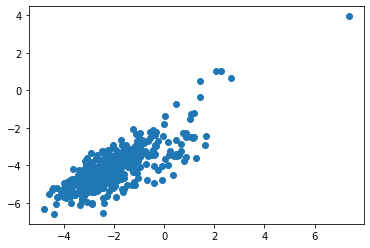

In [205]:
plt.scatter(np.log(np.mean(linguistic_activities, axis=0)), np.log(np.mean(acoustic_activities, axis=0)))

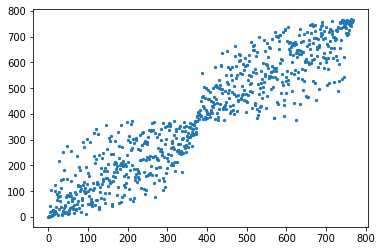

In [204]:
plt.scatter(x=utils.find_sorted_position(np.mean(linguistic_activities, axis=0)), y=utils.find_sorted_position(np.mean(acoustic_activities, axis=0)), s=5)

(array([ 1.,  3.,  6.,  5.,  9.,  3.,  3.,  4.,  8., 16., 19., 17., 23.,
        35., 27., 40., 33., 29., 32., 30., 57., 37., 52., 43., 37., 31.,
        35., 21., 26., 12.,  9., 14., 14.,  5.,  6.,  6.,  2.,  4.,  3.,
         1.,  3.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  2.]),
 array([-0.36707887, -0.34614977, -0.3252207 , -0.3042916 , -0.28336254,
        -0.26243344, -0.24150436, -0.22057527, -0.19964619, -0.1787171 ,
        -0.15778801, -0.13685893, -0.11592984, -0.09500076, -0.07407168,
        -0.05314258, -0.0322135 , -0.01128441,  0.00964467,  0.03057376,
         0.05150284,  0.07243193,  0.09336101,  0.1142901 ,  0.13521919,
         0.15614827,  0.17707735,  0.19800644,  0.21893552,  0.23986462,
         0.2607937 ,  0.28172278,  0.30265188,  0.32358095,  0.34451005,
         0.36543912,  0.38636822,  0.40729728,  0.42822638,  0.44915548,
         0.47008455,  0.49101365,  0.51194274,  0.5328718 ,  0.5538009 ,
         0.57473   ,  0.5956591 ,  0.6165882 ,  0.6375172 ,

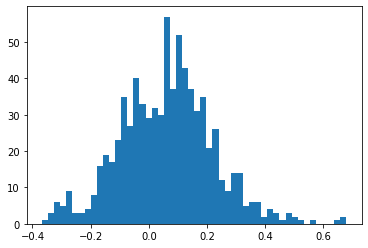

In [187]:
enum = (linguistic_activities - np.mean(linguistic_activities, axis=0)) * (acoustic_activities - np.mean(acoustic_activities, axis=0))
enum = np.mean(enum, axis=0)
denum = np.std(linguistic_activities, axis=0) * np.std(acoustic_activities, axis=0)
plt.hist(enum / denum, bins=50)

In [21]:
checkpoint_base = torch.load('./pretrained_checkpoints/wav2vec_small.pt')
checkpoint_finetune = torch.load('./pretrained_checkpoints/wav2vec_small_960h.pt')

In [22]:
wav2vec2 = Wav2Vec2Model.build_model(convert_namespace_to_omegaconf(checkpoint_base['args']).model, task='audio_pretraining')
wav2vec2.cuda()
wav2vec2.eval()

Wav2Vec2Model(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(512, 512, eps=1e-05, affine=True)
        (3): GELU()
      )
      (1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU()
      )
      (2): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU()
      )
      (3): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU()
      )
      (4): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU()
      )
      (5

In [23]:
# utils.reset_all_weights(wav2vec2)
# for key in checkpoint_finetune['model']:
#     if 'w2v_encoder.w2v_model.' == key[:len('w2v_encoder.w2v_model.')]:
#         checkpoint_base['model'][key[len('w2v_encoder.w2v_model.'):]] = checkpoint_finetune['model'][key]
wav2vec2.load_state_dict(checkpoint_base['model'])

<All keys matched successfully>

In [242]:
hf = h5py.File("./outputs/extracted_features/wav2vec2_small/TIMIT_train_averaged.h5", 'r')
df = pd.read_csv("./data/TIMIT_train.csv")

In [19]:
df_small = df.sample(200)

In [236]:
external_var_fixed_speaker = compute_external_var_label(hf, df, 'encoder_output', 'speaker')

In [237]:
external_var_fixed_sentence = compute_external_var_label(hf, df, 'encoder_output', 'sentence')

In [145]:
external_var = compute_external_var(hf, df, 'encoder_output')

In [126]:
internal_var = compute_internal_var(wav2vec2, df_small, 'encoder_output')

In [210]:
external_var_fixed_speaker /= neuron_means
external_var_fixed_sentence /= neuron_means

/tmp/ipykernel_6137/4045862634.py:1: RuntimeWarning: invalid value encountered in log
  plt.scatter(x=np.log(external_var_fixed_speaker), y=np.log(external_var_fixed_sentence))


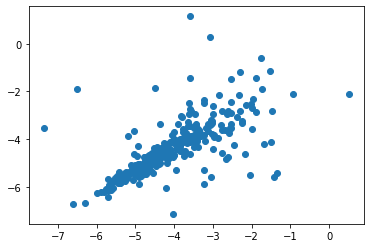

In [217]:
plt.scatter(x=np.log(external_var_fixed_speaker), y=np.log(external_var_fixed_sentence))

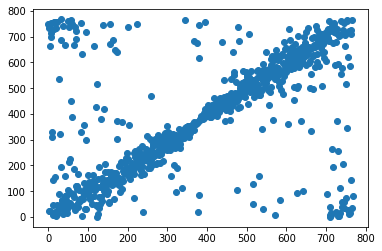

In [216]:
plt.scatter(x=utils.find_sorted_position(external_var_fixed_speaker), y=utils.find_sorted_position(external_var_fixed_sentence))

In [250]:
def plot(h5_path, normalize='rank'):
    hf = h5py.File(h5_path, 'r')
    f, ax = plt.subplots(2,3,figsize=(15,10))

    for i, feat in enumerate(['cnn_output', 'vq', 'projected_vq', 'encoder_output', 'context_vector']):
        linguistic_activities = compute_external_var_label(hf, df, feat, 'speaker')
        acoustic_activities = compute_external_var_label(hf, df, feat, 'sentence')

        if normalize == 'rank':
            rank_linguistic = utils.find_sorted_position(linguistic_activities)
            rank_acoustic = utils.find_sorted_position(acoustic_activities)
            ax[i//3, i%3].scatter(x=rank_linguistic, y=rank_acoustic, s=8)
        elif normalize == 'log':
            ax[i//3, i%3].scatter(x=np.log(linguistic_activities), y=np.log(acoustic_activities), s=8)
        ax[i//3, i%3].title.set_text(feat)    

/tmp/ipykernel_6137/2932910512.py:14: RuntimeWarning: invalid value encountered in log
  ax[i//3, i%3].scatter(x=np.log(linguistic_activities), y=np.log(acoustic_activities), s=8)


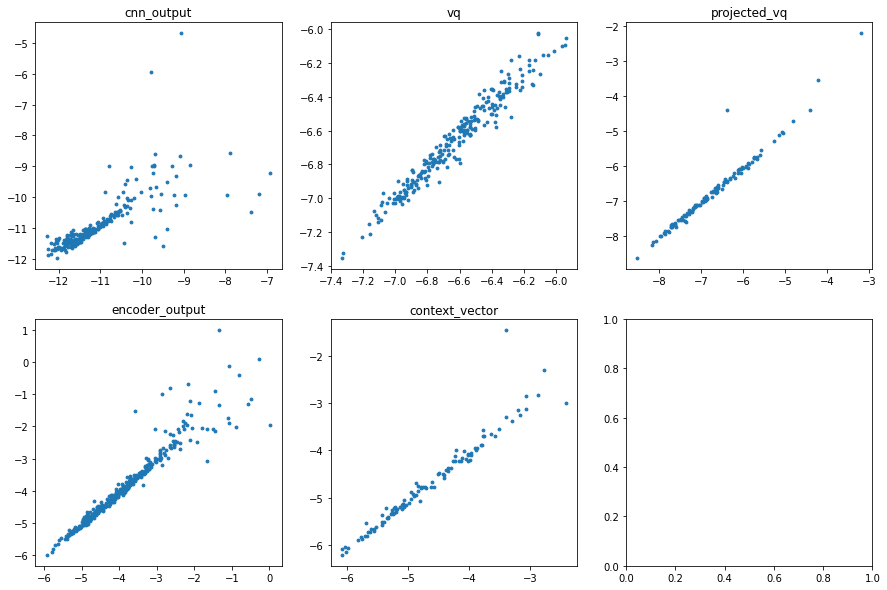

In [257]:
plot("./outputs/extracted_features/wav2vec2_small-random_init/TIMIT_train_averaged.h5", 'log')

## Latent manipulation

In [42]:
class MyWavTransform(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Conv1d(1, 1, kernel_size=15, padding='same')
        self.conv2 = torch.nn.Conv1d(1, 1, kernel_size=15, padding='same')
        self.conv3 = torch.nn.Conv1d(1, 1, kernel_size=15, padding='same')
    
    def forward(self, source):
        x = self.conv(source)
        x = torch.nn.ReLU()(x)
        x = self.conv2(x)
        x = torch.nn.ReLU()(x)
        x = self.conv3(x)
        y = torch.tanh(x)
#         x = torch.sigmoid(x)
#         y = source * x
        
        return y

In [127]:
x, sr = sf.read(df.iloc[3023]['wav_path'], dtype='float32')
x = x * 100
x = torch.autograd.Variable(torch.tensor(x).unsqueeze(0).cuda(), requires_grad=False)
#y = torch.autograd.Variable(torch.tensor(x).unsqueeze(0).cuda(), requires_grad=True)
with torch.no_grad():
    context_vec_org = wav2vec2featurize(wav2vec2, x, 'cnn_output')
    
IPython.display.Audio(data=x.cpu(), rate=16000)

In [126]:
torch.mean(torch.abs(context_vec_org))

tensor(0.0117, device='cuda:0')

In [43]:
# y = torch.autograd.Variable(torch.randn_like(x), requires_grad=True)
model = MyWavTransform()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999))

In [44]:
loss_func = torch.nn.L1Loss()

In [46]:
wav2vec2

Wav2Vec2Model(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(512, 512, eps=1e-05, affine=True)
        (3): GELU()
      )
      (1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU()
      )
      (2): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU()
      )
      (3): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU()
      )
      (4): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU()
      )
      (5

In [14]:
from fairseq.modules import Fp32LayerNorm,  TransposeLast

In [211]:
64**2

4096

In [31]:
class vec2wavModel(torch.nn.Module):
    def __init__(self, in_channel=256):
        super().__init__()
        self.deconv0 = torch.nn.ConvTranspose1d(in_channel, 512, kernel_size=2, stride=2, bias=False)
        self.layer_norm1 = Fp32LayerNorm(512, elementwise_affine=True)
        self.layer_norm2 = Fp32LayerNorm(256, elementwise_affine=True)
        self.deconv1 = torch.nn.ConvTranspose1d(512, 256, kernel_size=2, stride=2, bias=False)
        self.deconv2 = torch.nn.ConvTranspose1d(256, 128, kernel_size=3, stride=2, bias=False)
        self.deconv3 = torch.nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2, bias=False)
        self.deconv4 = torch.nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, bias=False)
        self.deconv5 = torch.nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, bias=False)
        self.deconv6 = torch.nn.ConvTranspose1d(16, 1, kernel_size=10, stride=5, bias=False)
        
        self.activation_func = torch.nn.GELU()
        
        
    def forward(self, x):
        x = self.deconv0(x)
        x = TransposeLast()(x)
        x = self.layer_norm1(x)
        x = TransposeLast()(x)
        x = self.activation_func(x)
        x = self.deconv1(x)
        x = TransposeLast()(x)
        x = self.layer_norm2(x)
        x = TransposeLast()(x)
        x = self.activation_func(x)
        x = self.deconv2(x)
        x = self.activation_func(x)
        x = self.deconv3(x)
        x = self.activation_func(x)
        x = self.deconv4(x)
        x = self.activation_func(x)
        x = self.deconv5(x)
        x = self.activation_func(x)
        x = self.deconv6(x)
#         x = self.activation_func(x)
        
        return x
        
        return x

In [207]:
wav2vec2

Wav2Vec2Model(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(512, 512, eps=1e-05, affine=True)
        (3): GELU()
      )
      (1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU()
      )
      (2): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU()
      )
      (3): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU()
      )
      (4): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU()
      )
      (5

In [17]:
import auraloss
sisdr_loss = auraloss.time.SISDRLoss()

In [272]:
d1 = h5py.File("./outputs/extracted_features/wav2vec2_small/TIMIT_train.h5")

In [142]:
d2 = h5py.File("./outputs/extracted_features/wav2vec2_small/TIMIT_train_averaged.h5")

In [214]:
# np.mean(d1['DR1_FCJF0_SA1.WAV-context_vector'][:], axis=0) - d2['DR1_FCJF0_SA1.WAV-context_vector'][:]

In [32]:
vec2wav = vec2wavModel(in_channel=768).cuda()
optimizer = torch.optim.Adam(vec2wav.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [71]:
len(vec2wav(context_vec_org.T.unsqueeze(0).cpu()))

1

In [279]:
d1['DR1_FCJF0_SA1.WAV-projected_vq'][:].shape

(145, 256)

In [256]:
checkpoint = torch.load('/mnt/scratch09/vnguyen/SpeakerRecognition/exp/tmp/recon_from_cnn_output/checkpoints/epoch=36-step=5364.ckpt')

In [26]:
vec2wav

vec2wavModel(
  (deconv0): ConvTranspose1d(768, 512, kernel_size=(2,), stride=(2,), bias=False)
  (layer_norm1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (layer_norm2): Fp32LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (deconv1): ConvTranspose1d(512, 256, kernel_size=(2,), stride=(2,), bias=False)
  (deconv2): ConvTranspose1d(256, 128, kernel_size=(3,), stride=(2,), bias=False)
  (deconv3): ConvTranspose1d(128, 64, kernel_size=(3,), stride=(2,), bias=False)
  (deconv4): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(2,), bias=False)
  (deconv5): ConvTranspose1d(32, 16, kernel_size=(3,), stride=(2,), bias=False)
  (deconv6): ConvTranspose1d(16, 1, kernel_size=(10,), stride=(5,), bias=False)
  (activation_func): GELU()
)

In [33]:
x, sr = sf.read(df.iloc[0]['wav_path'], dtype='float32')
x = torch.autograd.Variable(torch.tensor(x).unsqueeze(0).cuda(), requires_grad=False)
#y = torch.autograd.Variable(torch.tensor(x).unsqueeze(0).cuda(), requires_grad=True)
with torch.no_grad():
    context_vec_org = wav2vec2featurize(wav2vec2, x, 'encoder_output')
    
IPython.display.Audio(data=x.cpu(), rate=16000)


vec2wav.load_state_dict(checkpoint['state_dict'])
y = vec2wav(context_vec_org.T.unsqueeze(0)).squeeze(0)

RuntimeError: Error(s) in loading state_dict for vec2wavModel:
	Unexpected key(s) in state_dict: "deconv_layers.0.0.weight", "deconv_layers.0.2.weight", "deconv_layers.0.2.bias", "deconv_layers.1.0.weight", "deconv_layers.1.2.weight", "deconv_layers.1.2.bias", "deconv_layers.2.0.weight", "deconv_layers.2.2.weight", "deconv_layers.2.2.bias", "deconv_layers.3.0.weight", "deconv_layers.3.2.weight", "deconv_layers.3.2.bias", "deconv_layers.4.0.weight", "deconv_layers.4.2.weight", "deconv_layers.4.2.bias", "deconv_layers.5.0.weight", "deconv_layers.5.2.weight", "deconv_layers.5.2.bias", "final_deconv.weight". 

In [158]:
steps=10000
for i in range(steps):
    optimizer.zero_grad()
    y = vec2wav(context_vec_org.T.unsqueeze(0)).squeeze(0)
    #context_vec = wav2vec2featurize(wav2vec2, y, 'context_vector')
    #loss = loss_func(context_vec[:, list(idx)], target)
#     loss = sisdr_loss(y, x[:, :len(y[0])])
    loss = torch.nn.MSELoss()(y, x[:, :len(y[0])])
    if i % 1000 == 0:
        print(loss)
    loss.backward()
    optimizer.step()

tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1750e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.4610e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(3.3323e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.3002e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.8097e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5178e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


KeyboardInterrupt: 

In [260]:
sisdr_loss(y, x[:, :len(y[0])])

tensor(32.6852, device='cuda:0', grad_fn=<NegBackward0>)

In [233]:
sisdr_loss(torch.randn_like(y), x[:, :len(y[0])])

tensor(44.8981, device='cuda:0')

In [196]:
torch.nn.MSELoss()(y, x[:, :len(y[0])])

tensor(0.0271, device='cuda:0', grad_fn=<MseLossBackward0>)

In [198]:
torch.nn.MSELoss()(torch.zeros_like(y), x[:, :len(y[0])])

tensor(0.0008, device='cuda:0')

In [265]:
IPython.display.Audio(data=y.cpu().detach().numpy(), rate=16000)

In [263]:
IPython.display.Audio(data=x.cpu(), rate=16000)

In [161]:
df[:32]

,wav_id,wav_path,dialect,sentence,speaker
0,DR1_FCJF0_SA1.WAV,./data/data/TRAIN/DR1/FCJF0/SA1.WAV.wav,DR1,SA1,FCJF0
1,DR1_FCJF0_SA2.WAV,./data/data/TRAIN/DR1/FCJF0/SA2.WAV.wav,DR1,SA2,FCJF0
2,DR1_FCJF0_SI1027.WAV,./data/data/TRAIN/DR1/FCJF0/SI1027.WAV.wav,DR1,SI1027,FCJF0
3,DR1_FCJF0_SI1657.WAV,./data/data/TRAIN/DR1/FCJF0/SI1657.WAV.wav,DR1,SI1657,FCJF0
4,DR1_FCJF0_SI648.WAV,./data/data/TRAIN/DR1/FCJF0/SI648.WAV.wav,DR1,SI648,FCJF0
5,DR1_FCJF0_SX127.WAV,./data/data/TRAIN/DR1/FCJF0/SX127.WAV.wav,DR1,SX127,FCJF0
6,DR1_FCJF0_SX217.WAV,./data/data/TRAIN/DR1/FCJF0/SX217.WAV.wav,DR1,SX217,FCJF0
7,DR1_FCJF0_SX307.WAV,./data/data/TRAIN/DR1/FCJF0/SX307.WAV.wav,DR1,SX307,FCJF0
8,DR1_FCJF0_SX37.WAV,./data/data/TRAIN/DR1/FCJF0/SX37.WAV.wav,DR1,SX37,FCJF0
9,DR1_FCJF0_SX397.WAV,./data/data/TRAIN/DR1/FCJF0/SX397.WAV.wav,DR1,SX397,FCJF0


In [24]:
idx = 14

x, sr = sf.read(df.iloc[idx]['wav_path'], dtype='float32')
x = torch.autograd.Variable(torch.tensor(x).unsqueeze(0).cuda(), requires_grad=False)
#y = torch.autograd.Variable(torch.tensor(x).unsqueeze(0).cuda(), requires_grad=True)
with torch.no_grad():
    context_vec_org = wav2vec2featurize(wav2vec2, x, 'cnn_output')
    
IPython.display.Audio(data=x.cpu(), rate=16000)

In [332]:
hop_length = 320
t1 = torch.stft(x[0], n_fft=1024, win_length=720, hop_length=hop_length)

In [350]:
torch.sqrt(t1[:,:,0]**2 + t1[:,:,1]**2)

tensor([[0.0200, 0.0229, 0.0258,  ..., 0.0261, 0.0240, 0.0192],
        [0.0064, 0.0086, 0.0109,  ..., 0.0093, 0.0076, 0.0082],
        [0.0069, 0.0065, 0.0034,  ..., 0.0059, 0.0075, 0.0029],
        ...,
        [0.0009, 0.0009, 0.0020,  ..., 0.0005, 0.0004, 0.0009],
        [0.0011, 0.0015, 0.0010,  ..., 0.0011, 0.0005, 0.0010],
        [0.0011, 0.0011, 0.0028,  ..., 0.0020, 0.0010, 0.0019]],
       device='cuda:0')

In [5]:
import torchaudio
transformer = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=1024, win_length=720, hop_length=320)

In [71]:
import librosa

In [88]:
spec = librosa.stft(x.cpu().numpy()[0], n_fft=1024, hop_length=320, win_length=720)

In [150]:
s, sr = sf.read('/mnt/scratch09/vnguyen/datasets/LibriSpeech/dev-clean/1272/128104/1272-128104-0000.wav', dtype='float32')

In [196]:
wav2spec_converter = torchaudio.transforms.Spectrogram(n_fft=1024, win_length=720, hop_length=320, power=None)
spec2wav_converter = torchaudio.transforms.InverseSpectrogram(n_fft=1024, hop_length=320, win_length=720)

In [197]:
spec = wav2spec_converter(torch.tensor(s))

In [210]:
spec.shape

torch.Size([513, 147])

In [205]:
recon = spec2wav_converter(spec.real.type(torch.complex64))

In [216]:
torch.min(torch.abs(spec.real))

tensor(9.9305e-09)

In [103]:
spec.real**2

array([[8.3077891e-04, 9.1211713e-04, 9.1522443e-04, ..., 3.1314645e-04,
        4.3421082e-04, 1.7275696e-04],
       [3.7656914e-04, 4.7469890e-04, 4.4974306e-04, ..., 1.5158979e-04,
        2.4333535e-04, 7.9525184e-05],
       [8.1689350e-06, 3.7399714e-05, 2.6209937e-05, ..., 1.0108261e-05,
        3.8400904e-05, 3.6105748e-06],
       ...,
       [8.9088822e-08, 5.9336158e-09, 1.9677881e-07, ..., 5.8756786e-08,
        7.0771428e-08, 2.6305903e-08],
       [1.7661776e-09, 1.3164185e-07, 8.2304163e-10, ..., 4.8458213e-07,
        5.7721124e-08, 3.1956071e-09],
       [8.2486700e-08, 2.5655146e-07, 1.7170751e-07, ..., 8.3692930e-07,
        9.3250193e-08, 2.4934559e-08]], dtype=float32)

In [101]:
recon = librosa.istft(spec.real, hop_length=320, win_length=720)

In [206]:
IPython.display.Audio(data=recon, rate=16000)

In [389]:
melspec = transformer.cuda()(x)

In [390]:
recon = torchaudio.transforms.InverseMelScale(sample_rate=16000, n_stft=513).cuda()(melspec)

In [408]:
recon_x = torchaudio.transforms.GriffinLim(n_fft=1024, win_length=720, hop_length=320).cuda()(recon[0])

In [ ]:
!mkdir ./data/TIMIT/train/

In [248]:
h5out = h5py.File("./data/TIMIT/train/melSpectrogram.h5", 'r')

In [250]:
h5out['DR1_FCJF0_SA1.WAV'][:].shape

(147, 128)

In [209]:
for i, row in df.iterrows():
    x, sr = sf.read(df.iloc[i]['wav_path'], dtype='float32')
#     x = torch.tensor(x).unsqueeze(0).cuda()
#     melspec = transformer(x)
#     spec = librosa.stft(x, n_fft=1024, hop_length=320, win_length=720)
#     h5out.create_dataset(row['wav_id'], data=melspec.cpu().numpy()[0,:,:].T)
    spec = wav2spec_converter(torch.tensor(x))
    h5out.create_dataset(row['wav_id'], data=spec.real.T)

torch.Size([513, 147])


ValueError: Invalid location identifier (invalid location identifier)

In [140]:
h5out.close()

In [62]:
x, sr = sf.read(df.iloc[0]['wav_path'], dtype='float32')
x = torch.tensor(x).unsqueeze(0).cuda()
melspec = transformer(x)
melspec = torchaudio.transforms.InverseMelScale(sample_rate=16000, n_stft=513).cuda()(melspec)
recon_x = torchaudio.transforms.GriffinLim(n_fft=1024, win_length=720, hop_length=320).cuda()(melspec[0])

RuntimeError: stft input and window must be on the same device but got self on cuda:0 and window on cpu

In [310]:
layers = list(wav2vec2.feature_extractor.children())[0]

In [19]:
melspec

tensor([[[2.5039e-05, 5.9398e-05, 3.3593e-05,  ..., 6.2098e-05,
          5.3531e-05, 5.0156e-05],
         [3.7339e-06, 1.3890e-05, 9.4852e-06,  ..., 1.2009e-05,
          1.1671e-05, 1.2095e-05],
         [7.1024e-06, 2.5778e-06, 3.4518e-06,  ..., 2.0437e-06,
          1.9877e-06, 2.2134e-06],
         ...,
         [4.7246e-05, 2.2369e-04, 9.0367e-05,  ..., 5.2730e-06,
          9.4699e-06, 3.0931e-06],
         [1.7072e-05, 1.2881e-04, 2.0948e-04,  ..., 3.7213e-06,
          1.1316e-05, 4.5927e-06],
         [4.1509e-05, 3.7926e-05, 1.0363e-04,  ..., 4.3772e-06,
          4.1792e-06, 7.9309e-06]]], device='cuda:0')

In [327]:
(40653 - 10) // 5 + 1

8129

In [324]:
layers[0](x.unsqueeze(0)).shape

torch.Size([1, 512, 8129])

In [301]:
x.shape[1] / context_vec_org.shape[0]

322.4850746268657

In [204]:
torch.mean(t1.abs())

tensor(12.6628)

In [9]:
IPython.display.Audio(data=recon_x.cpu().detach().numpy(), rate=16000)

In [14]:
context_vec_org[:, np.where(acoustic_activities < 0.9)] = 0

NameError: name 'context_vec_org' is not defined

In [27]:
target = torch.zeros_like(context_vec_org[:, list(idx)])

In [24]:
context_vec_org = torch.randn_like(context_vec_org).cuda()

In [21]:
idx = np.where(acoustic_activities < 0.9)[0]

In [21]:
acoustic_activities.shape

(256,)

In [18]:
acoustic_activities[acoustic_activities< 0.9]

array([0.8798058 , 0.849522  , 0.84498537, 0.8879668 , 0.8710466 ,
       0.76367974, 0.89725477, 0.8888698 , 0.84808457, 0.85850203,
       0.87801343, 0.83499837, 0.8480433 , 0.8756088 , 0.87656486,
       0.8072719 , 0.8097518 , 0.87637246, 0.834342  , 0.81153375,
       0.8678118 , 0.88660187, 0.89026284, 0.8544091 , 0.8915926 ,
       0.8187305 , 0.887724  , 0.88102096, 0.88733727, 0.87694013,
       0.86047876, 0.8314651 , 0.8399152 , 0.89973843, 0.8872277 ,
       0.8555444 , 0.8954292 , 0.87559474, 0.8664348 , 0.8925186 ,
       0.82320154, 0.8704509 , 0.8641979 , 0.8485296 , 0.86933243,
       0.8818338 , 0.8350353 , 0.8591113 , 0.839474  , 0.8948697 ,
       0.89828956, 0.8957679 , 0.83023494, 0.89056665, 0.8609578 ],
      dtype=float32)

# Reconstruct input

In [39]:
import pytorch_lightning as pl
import torch.nn as nn

class Spec2Wav(pl.LightningModule):
    def __init__(self, in_channel=256):
        super().__init__()
        self.linear_layers = torch.nn.ModuleList()
        for i in range(2):
            self.linear_layers.append(nn.Linear(in_features=in_channel, out_features=in_channel))
        self.final_linear = nn.Linear(in_features=in_channel, out_features=128)
        
        self.activation_func = torch.nn.GELU()
        
        
    def forward(self, x):
        for layer in self.linear_layers:
            x = layer(x)
            x = self.activation_func(x)
        
        x = self.final_linear(x)
        x = torch.exp(x)
        
        return x

In [54]:
model = Spec2Wav(768).cuda()

In [217]:
checkpoint = torch.load("/mnt/scratch09/vnguyen/SpeakerRecognition/exp/wav2vec2_small/recon_from_encoder_output_melspec_logloss/checkpoints/epoch=41-step=6089.ckpt")

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/scratch09/vnguyen/SpeakerRecognition/exp/wav2vec2_small/recon_from_encoder_output_melspec_logloss/checkpoints/epoch=8-step=1304'

In [55]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [46]:
import torchaudio
transformer = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=1024, win_length=720, hop_length=320)

In [67]:
import torchaudio
transformer = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=1024, win_length=720, hop_length=320)

x, sr = sf.read(df.iloc[0]['wav_path'], dtype='float32')
x = torch.tensor(x).unsqueeze(0)

with torch.no_grad():
    hidden = wav2vec2featurize(wav2vec2, x.cuda(), 'encoder_output')
    melspec = model(hidden)

melspec = torchaudio.transforms.InverseMelScale(sample_rate=16000, n_stft=513).cuda()(melspec.T)
recon_x = torchaudio.transforms.GriffinLim(n_fft=1024, win_length=720, hop_length=320).cuda()(melspec)

In [70]:
IPython.display.Audio(data=recon_x.cpu().detach().numpy(), rate=16000)

In [69]:
IPython.display.Audio(data=x.cpu().detach().numpy(), rate=16000)

In [3]:
df = pd.read_csv("./data/TIMIT_test.csv")

In [4]:
df

,Unnamed: 0,wav_id,wav_path,dialect,speaker,sentence
0,0,DR1_FAKS0_SA1,./data/data/TEST/DR1/FAKS0/SA1.WAV.wav,DR1,FAKS0,SA1
1,1,DR1_FAKS0_SA2,./data/data/TEST/DR1/FAKS0/SA2.WAV.wav,DR1,FAKS0,SA2
2,2,DR1_FAKS0_SI1573,./data/data/TEST/DR1/FAKS0/SI1573.WAV.wav,DR1,FAKS0,SI1573
3,3,DR1_FAKS0_SI2203,./data/data/TEST/DR1/FAKS0/SI2203.WAV.wav,DR1,FAKS0,SI2203
4,4,DR1_FAKS0_SI943,./data/data/TEST/DR1/FAKS0/SI943.WAV.wav,DR1,FAKS0,SI943
...,...,...,...,...,...,...
1675,1675,DR8_MSLB0_SX113,./data/data/TEST/DR8/MSLB0/SX113.WAV.wav,DR8,MSLB0,SX113
1676,1676,DR8_MSLB0_SX203,./data/data/TEST/DR8/MSLB0/SX203.WAV.wav,DR8,MSLB0,SX203
1677,1677,DR8_MSLB0_SX23,./data/data/TEST/DR8/MSLB0/SX23.WAV.wav,DR8,MSLB0,SX23
1678,1678,DR8_MSLB0_SX293,./data/data/TEST/DR8/MSLB0/SX293.WAV.wav,DR8,MSLB0,SX293


In [231]:
IPython.display.Audio(df[df['sentence']=='SA1'].iloc[0]['wav_path'])

In [232]:
IPython.display.Audio(df[df['sentence']=='SA2'].iloc[0]['wav_path'])

In [244]:
df = df.drop(list(df[df['sentence']=='SA2'].sample(462-20).index))

In [245]:
df = df.drop(list(df[df['sentence']=='SA1'].sample(462-20).index))

In [259]:
a = torch.tensor(np.arange(24).reshape((2,3,4)))

In [271]:
torch.hstack([a[0], a[1]])

tensor([[ 0,  1,  2,  3, 12, 13, 14, 15],
        [ 4,  5,  6,  7, 16, 17, 18, 19],
        [ 8,  9, 10, 11, 20, 21, 22, 23]])

In [286]:
for speaker in set(df['speaker']):
    l = len(df[df['speaker']==speaker])
    if l != 10:
        print(speaker)

In [289]:
tmp = df[df['speaker']==speaker]

In [293]:
for i in range(len(df)):
    df.iloc[i]['wav_id'] = df.iloc[i]['wav_id'].split('.')[0]
    df.iloc[i]['sentence'] = df.iloc[i]['sentence'].split('.')[0]

In [13]:
h5_old = h5py.File("./data/TIMIT/test/spectrogram.h5", 'r')

In [16]:
h5_old.close()

In [14]:
h5_new = h5py.File("./data/TIMIT/test/spectrogram_new.h5", 'w')

In [17]:
h5_new.close()

In [15]:
for key in h5_old.keys():
    new_key = key.split('.')[0]
    h5_new.create_dataset(new_key, data=h5_old[key][:])

In [2]:
with h5py.File("./outputs/extracted_features/wav2vec2_small/TIMIT_test.h5",  "w") as f:
    for key in f.keys():
        new_key = key.split('.')[0] + key.split('-')[1]
        f.create_dataset(new_key, data=f[key][:])
        del f[key]

BlockingIOError: [Errno 11] Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

In [300]:
h5.keys()

<KeysViewHDF5 ['DR1_FAKS0_SA1.WAV-cnn_output', 'DR1_FAKS0_SA1.WAV-context_vector', 'DR1_FAKS0_SA1.WAV-encoder_output', 'DR1_FAKS0_SA1.WAV-projected_vq', 'DR1_FAKS0_SA1.WAV-vq', 'DR1_FAKS0_SA2.WAV-cnn_output', 'DR1_FAKS0_SA2.WAV-context_vector', 'DR1_FAKS0_SA2.WAV-encoder_output', 'DR1_FAKS0_SA2.WAV-projected_vq', 'DR1_FAKS0_SA2.WAV-vq', 'DR1_FAKS0_SI1573.WAV-cnn_output', 'DR1_FAKS0_SI1573.WAV-context_vector', 'DR1_FAKS0_SI1573.WAV-encoder_output', 'DR1_FAKS0_SI1573.WAV-projected_vq', 'DR1_FAKS0_SI1573.WAV-vq', 'DR1_FAKS0_SI2203.WAV-cnn_output', 'DR1_FAKS0_SI2203.WAV-context_vector', 'DR1_FAKS0_SI2203.WAV-encoder_output', 'DR1_FAKS0_SI2203.WAV-projected_vq', 'DR1_FAKS0_SI2203.WAV-vq', 'DR1_FAKS0_SI943.WAV-cnn_output', 'DR1_FAKS0_SI943.WAV-context_vector', 'DR1_FAKS0_SI943.WAV-encoder_output', 'DR1_FAKS0_SI943.WAV-projected_vq', 'DR1_FAKS0_SI943.WAV-vq', 'DR1_FAKS0_SX133.WAV-cnn_output', 'DR1_FAKS0_SX133.WAV-context_vector', 'DR1_FAKS0_SX133.WAV-encoder_output', 'DR1_FAKS0_SX133.WAV-proj

In [22]:
df = pd.read_csv("./data/TIMIT_train.csv")
genders =  [s[0] for s in list(df['speaker'])]

In [23]:
df['gender'] = genders

In [24]:
df.to_csv('./data/TIMIT_train.csv', index=False)